In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-09-24 11:38:07--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-09-24 11:38:07 (5.56 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



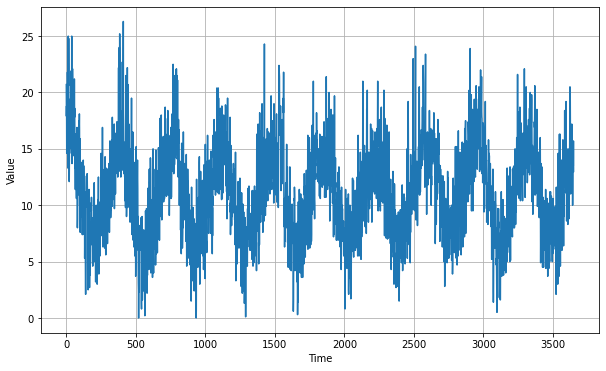

In [3]:
import csv

time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 9s 363ms/step - loss: 31.1418 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 4s 358ms/step - loss: 30.5657 - mae: 31.0639
Epoch 3/100
10/10 [==============================] - 4s 344ms/step - loss: 29.6745 - mae: 30.1726
Epoch 4/100
10/10 [==============================] - 4s 349ms/step - loss: 28.5571 - mae: 29.0549
Epoch 5/100
10/10 [==============================] - 4s 347ms/step - loss: 27.1948 - mae: 27.6923
Epoch 6/100
10/10 [==============================] - 4s 354ms/step - loss: 25.4979 - mae: 25.9952
Epoch 7/100
10/10 [==============================] - 4s 347ms/step - loss: 23.3389 - mae: 23.8356
Epoch 8/100
10/10 [==============================] - 4s 340ms/step - loss: 20.5994 - mae: 21.0955
Epoch 9/100
10/10 [==============================] - 4s 340ms/step - loss: 17.2908 - mae: 17.7858
Epoch 10/100
10/10 [==============================] - 4s 340ms/step - loss: 13.6042 - mae: 14.0969
Epoch 11/100
10/10 

(1e-08, 0.0001, 0.0, 60.0)

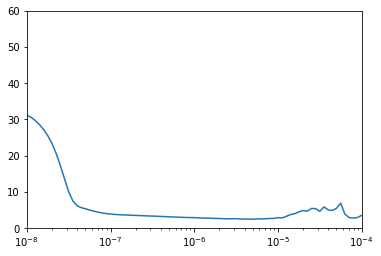

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, 
                             shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=150)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 8s 143ms/step - loss: 9.8779 - mae: 10.3646
Epoch 2/150
25/25 [==============================] - 4s 142ms/step - loss: 2.7314 - mae: 3.1974
Epoch 3/150
25/25 [==============================] - 4s 151ms/step - loss: 2.4402 - mae: 2.9027
Epoch 4/150
25/25 [==============================] - 4s 143ms/step - loss: 2.3559 - mae: 2.8171
Epoch 5/150
25/25 [==============================] - 4s 139ms/step - loss: 2.4638 - mae: 2.9259
Epoch 6/150
25/25 [==============================] - 4s 141ms/step - loss: 2.3707 - mae: 2.8321
Epoch 7/150
25/25 [==============================] - 4s 141ms/step - loss: 2.3192 - mae: 2.7789
Epoch 8/150
25/25 [==============================] - 4s 141ms/step - loss: 2.4246 - mae: 2.8867
Epoch 9/150
25/25 [==============================] - 4s 140ms/step - loss: 2.2862 - mae: 2.7463
Epoch 10/150
25/25 [==============================] - 4s 142ms/step - loss: 2.2907 - mae: 2.7501
Epoch 11/150
25/25 [==================

In [11]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)

lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

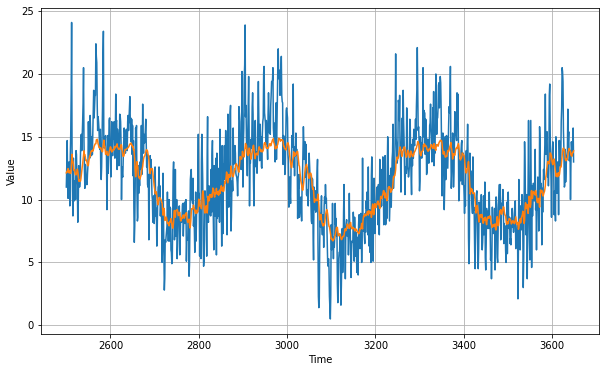

In [12]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

2.0382748

In [14]:
print(lstm_forecast)

[12.127531 12.237677 12.194006 ... 13.760304 13.750839 13.882059]
